<a href="https://colab.research.google.com/github/tinycar2008/cnn-detect-covid/blob/main/20241123_Assignment11_COVIDsymptoms_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: COVID Symptoms

In this assignment, build a model to help recognize COVID symptoms found in the CT scans
provided. You are given the CT scan, lung mask and infection mask to detect the lung infections in individuals.
Dataset can be found here
[link text](https://www.kaggle.com/code/andrewmvd/covid-19-ct-scans-getting-started/input)

## About this dataset

CT scans plays a supportive role in the diagnosis of COVID-19 and is a key procedure for determining the severity that the patient finds himself in.
Models that can find evidence of COVID-19 and/or characterize its findings can play a crucial role in optimizing diagnosis and treatment, especially in areas with a shortage of expert radiologists.
This dataset contains 20 CT scans of patients diagnosed with COVID-19 as well as segmentations of lungs and infections made by experts.

[link text](https://www.kaggle.com/code/andrewmvd/covid-19-ct-scans-getting-started)



This Version 6 has produced the best results:
-> Layered training data
-> However, data was not training before and just ended up being 1.
-> Used: "the Glorot uniform initializer, also called Xavier uniform initializer." which enabled the model start learning.


1. Utilisied ResNet
2. Tried to train a 3D model, which did not work well with the UNet model
3. Changed the datat processing and layered masks
4. Changed the Unet model
5. Changed to GlorotUniform initializer

==> Need to review the 3D layer selected.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imghdr
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing import image
from keras.utils import plot_model
import seaborn as sns

In [ ]:
pip install nibabel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.0 MB/s eta 0:00:00


In [ ]:
pip install kaggle

In [ ]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans -p /content/drive/MyDrive/03_Training/00_KaleAcademy_Bootcamp/Assignment_11_CovidSymptoms/covid19-ct-scans --unzip


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/covid19-ct-scans
License(s): other
 99% 1.03G/1.03G [00:11<00:00, 124MB/s]
100% 1.03G/1.03G [00:11<00:00, 96.3MB/s]


In [ ]:
covid_df = pd.read_csv('/content/drive/MyDrive/03_Training/00_KaleAcademy_Bootcamp/Assignment_11_CovidSymptoms/covid19-ct-scans/metadata.csv')

In [ ]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ct_scan                  20 non-null     object
 1   lung_mask                20 non-null     object
 2   infection_mask           20 non-null     object
 3   lung_and_infection_mask  20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


In [ ]:
covid_df.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
1,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
2,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
3,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
4,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...


In [ ]:
#had to restart colab and this step has been already done

csv_file_path = '/content/drive/MyDrive/03_Training/00_KaleAcademy_Bootcamp/Assignment_11_CovidSymptoms/covid19-ct-scans/metadata.csv'

df = pd.read_csv(csv_file_path)

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: x.replace('../input', '/content/drive/MyDrive/03_Training/00_KaleAcademy_Bootcamp/Assignment_11_CovidSymptoms') if isinstance(x, str) else x)

df.to_csv(csv_file_path, index=False)

In [ ]:
df = covid_df.copy()

In [ ]:
df.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
1,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
2,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
3,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...
4,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...,/content/drive/MyDrive/03_Training/00_KaleAcad...


In [ ]:
df.ct_scan[0]

'/content/drive/MyDrive/03_Training/00_KaleAcademy_Bootcamp/Assignment_11_CovidSymptoms/covid19-ct-scans/ct_scans/coronacases_org_001.nii'

In [ ]:
len(df['ct_scan'])

20

In [ ]:
# Define file paths

lung_mask_dir = df.loc[0:20, 'lung_mask']
infection_mask_dir = df.loc[0:20, 'infection_mask']
original_image_dir = df.loc[0:20, 'ct_scan']
lung_and_infection_mask_dir = df.loc[0:20, 'lung_and_infection_mask']

In [ ]:
import nibabel as nib
import numpy as np

def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample
sample_ct   = read_nii(df.loc[0,'ct_scan'])
sample_lung = read_nii(df.loc[0,'lung_mask'])
sample_infe = read_nii(df.loc[0,'infection_mask'])
sample_all  = read_nii(df.loc[0,'lung_and_infection_mask'])

In [ ]:
sample_ct.shape

(512, 512, 301)

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

In [ ]:
def bulk_plot_sample(array_list, index_list):
    '''
    Plots multiple slices, wrapper of plot_sample
    '''
    for index_value in index_list:
        plot_sample([array_list[0][...,index_value], array_list[1][...,index_value], array_list[2][...,index_value], array_list[3][...,index_value]])

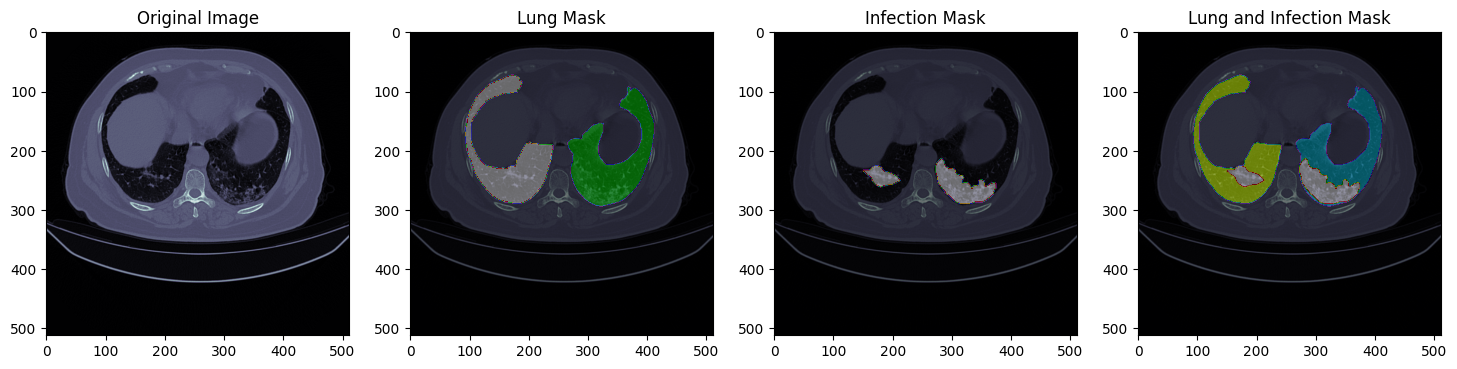

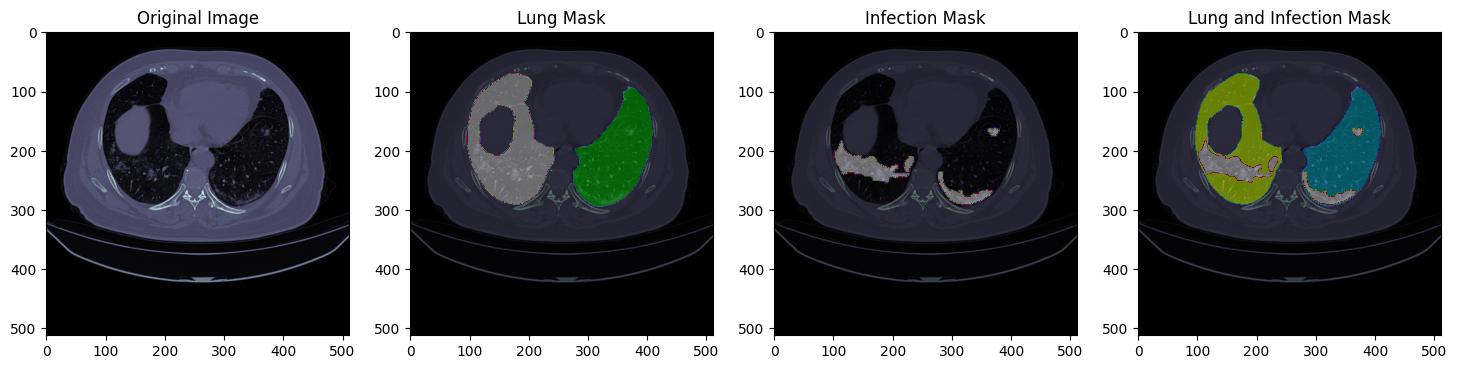

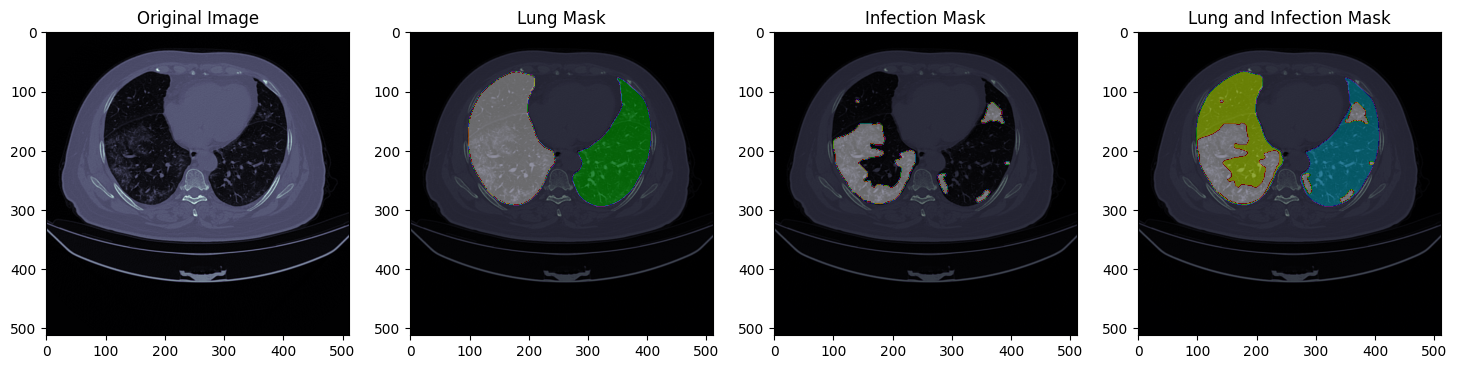

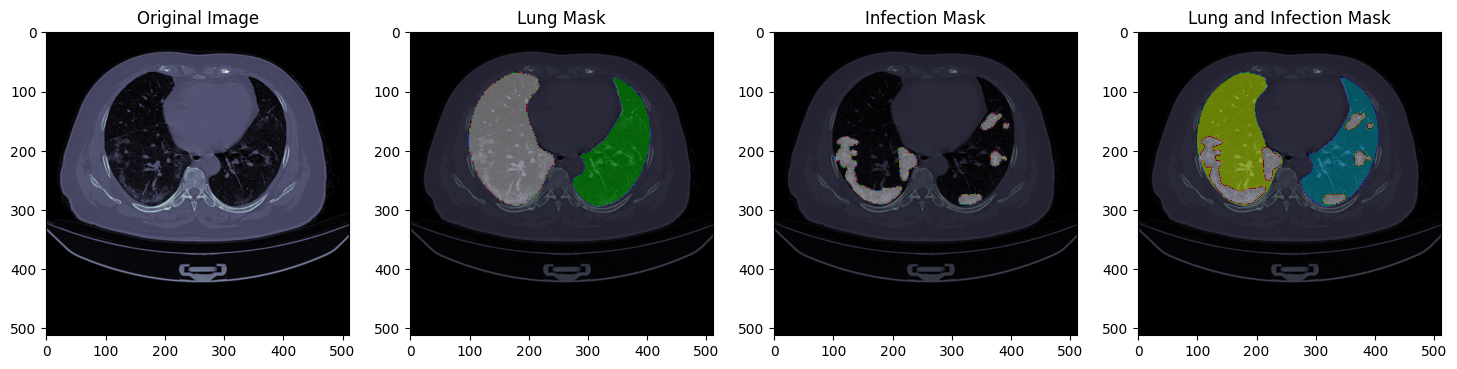

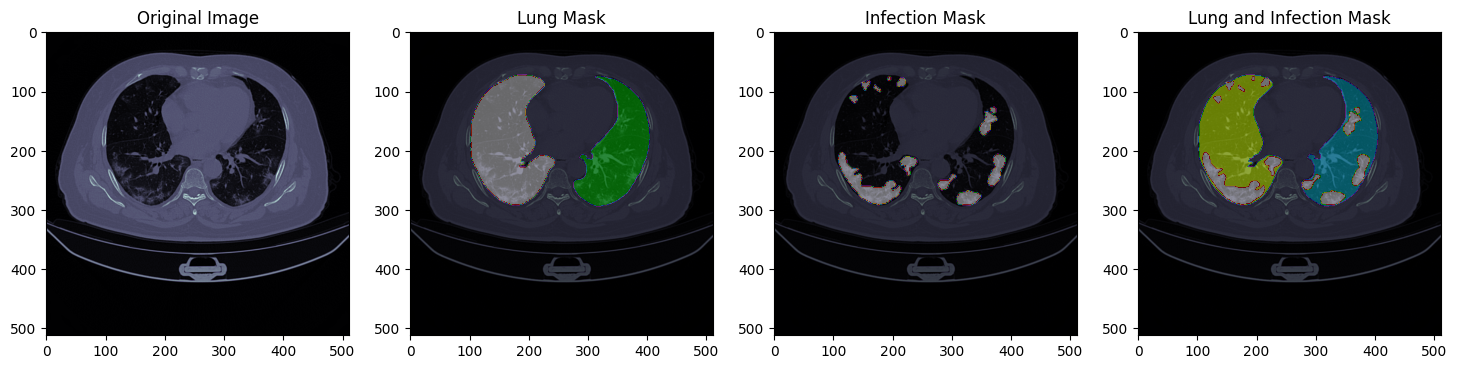

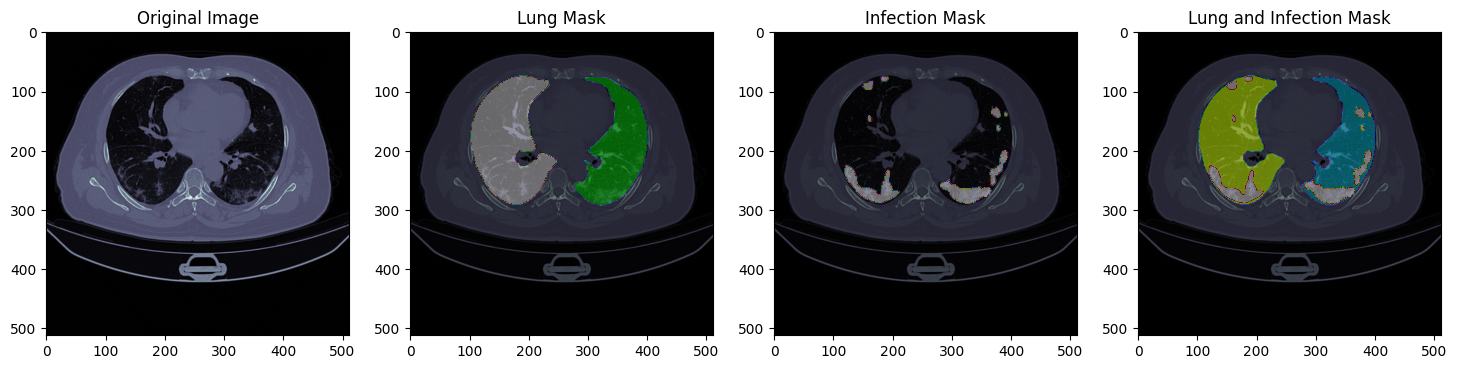

In [ ]:
# Examine multiple slices of a ct scan and its annotations
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], index_list=[100,110,120,130,140,150])

In [ ]:
#read_nii for each column and reszie to 244, 244, RGB channel

def read_nii_and_resize(filepath):
    """
    Reads a .nii file, resizes it to 244x244 with RGB channels,
    and returns the pixel array.
    """
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))

    # Select a specific slice from the 3D array for resizing
    # You can choose a different slice index as needed
    slice_index = array.shape[-1] // 2  # Example: select the middle slice
    array = array[..., slice_index]

    # Convert the selected slice to uint8 before resizing
    array = array.astype(np.uint8)

    # Resize to 244x244 using Pillow
    image_pil = Image.fromarray(array)
    resized_image = image_pil.resize((224, 224))
    resized_array = np.array(resized_image)

    # Add RGB channels if necessary
    if resized_array.ndim == 2:  # Grayscale image
        resized_array = np.stack((resized_array,) * 3, axis=-1)  # Replicate to RGB

    return resized_array

In [ ]:
lung_mask_resized = read_nii_and_resize(df.lung_mask[0])

In [ ]:
print(lung_mask_resized.shape)

(224, 224, 3)


In [ ]:
!pip install Pillow
from PIL import Image

In [ ]:
df['resized_lung_mask'] = df['lung_mask'].apply(read_nii_and_resize)
df['resized_infection_mask'] = df['infection_mask'].apply(read_nii_and_resize)
df['resized_ct_scan'] = df['ct_scan'].apply(read_nii_and_resize)
df['resized_lung_and_infection_mask'] = df['lung_and_infection_mask'].apply(read_nii_and_resize)

In [ ]:
import numpy as np

def layer_images(row):
  """
  Creates an overlay image by blending original image, lung mask, and infection mask.

  Args:
    row: A row of the dataframe containing paths to the images.

  Returns:
    The overlay image as a NumPy array.
  """
  # Read images using the read_nii function (make sure it's defined)
  original_image = row['resized_ct_scan']
  lung_mask = row['resized_lung_mask']
  infection_mask = row['resized_infection_mask']

  # Create an empty overlay image with 3 channels (RGB)
  overlay = np.zeros((original_image.shape), dtype=np.uint8)

  # Assign original image to the first channel (Red)
  overlay[..., 0] = original_image[..., 0]  # Assuming original image is already RGB

  # Assign lung mask to the second channel (Green)
  overlay[..., 1] = lung_mask[..., 0] * 255  # Scale to 0-255 for visibility

  # Assign infection mask to the third channel (Blue)
  overlay[..., 2] = infection_mask[..., 0] * 255  # Scale to 0-255 for visibility

  return overlay

In [ ]:
# Apply the function to create the "overlay" column
df['overlay'] = df.apply(layer_images, axis=1)

In [ ]:
df.overlay[0].shape

(224, 224, 3)

In [ ]:
len(df.overlay)

20

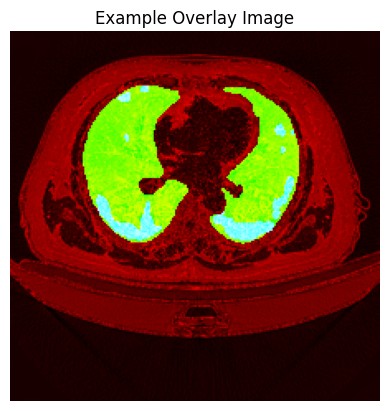

In [ ]:
import matplotlib.pyplot as plt

# Select an example overlay image (e.g., the first one)
example_overlay = df['overlay'][0]

# Display the image using imshow
plt.imshow(example_overlay)
plt.title('Example Overlay Image')
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

## Data Processing for 2D image classification

In [ ]:
import tensorflow as tf  # for data preprocessing
import keras
from keras import layers
import nibabel as nib
from scipy import ndimage

## Build training dataset

In [ ]:
lung_train = df['overlay']
covid_segmentation_mask = df['resized_infection_mask']

In [ ]:
#Split data into train and validation

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(lung_train, covid_segmentation_mask, test_size=0.2, random_state=42)

In [ ]:
def convert_and_normalize_series(overlay_series):
    arrays = [arr for arr in overlay_series.values]
    stacked = np.stack(arrays, axis=0)
    normalized = stacked.astype(np.float32) / 255.0
    return tf.convert_to_tensor(normalized, dtype=tf.float32)

In [ ]:
# Convert and normalize the data
try:
    X_train_tensor = convert_and_normalize_series(X_train)
    print("Conversion successful!")
    print("Tensor shape:", X_train_tensor.shape)
    print("Value range:", tf.reduce_min(X_train_tensor).numpy(), "to", tf.reduce_max(X_train_tensor).numpy())
except Exception as e:
    print(f"Error during conversion: {e}")

Conversion successful!
Tensor shape: (16, 224, 224, 3)
Value range: 0.0 to 1.0


In [ ]:
# Convert and normalize the data
try:
    X_test_tensor = convert_and_normalize_series(X_test)
    print("Conversion successful!")
    print("Tensor shape:", X_test_tensor.shape)
    print("Value range:", tf.reduce_min(X_test_tensor).numpy(), "to", tf.reduce_max(X_test_tensor).numpy())
except Exception as e:
    print(f"Error during conversion: {e}")

Conversion successful!
Tensor shape: (4, 224, 224, 3)
Value range: 0.0 to 1.0


In [ ]:
# Convert and normalize the data
try:
    y_train_tensor = convert_and_normalize_series(y_train)
    print("Conversion successful!")
    print("Tensor shape:", y_train_tensor.shape)
    print("Value range:", tf.reduce_min(y_train_tensor).numpy(), "to", tf.reduce_max(y_train_tensor).numpy())
except Exception as e:
    print(f"Error during conversion: {e}")

Conversion successful!
Tensor shape: (16, 224, 224, 3)
Value range: 0.0 to 0.003921569


In [ ]:
# Convert and normalize the data
try:
    y_test_tensor = convert_and_normalize_series(y_test)
    print("Conversion successful!")
    print("Tensor shape:", y_test_tensor.shape)
    print("Value range:", tf.reduce_min(y_test_tensor).numpy(), "to", tf.reduce_max(y_test_tensor).numpy())
except Exception as e:
    print(f"Error during conversion: {e}")

Conversion successful!
Tensor shape: (4, 224, 224, 3)
Value range: 0.0 to 0.003921569


## Build Data Augmentation

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/3D_image_classification.ipynb#scrollTo=guJjEx73hpGX

In [ ]:
import random

In [ ]:
def train_preprocessing(image, label):
    """Process training data with augmentation."""
    # Cast to float32
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)

    # Random flipping
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)

    # Random rotation
    random_angle = tf.random.uniform((), minval=-0.2, maxval=0.2)
    image = tf.image.rot90(image, k=tf.cast(random_angle * 2, tf.int32))
    label = tf.image.rot90(label, k=tf.cast(random_angle * 2, tf.int32))

    # Random brightness (only for image, not label)
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast (only for image, not label)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    # Resize to target size
    image = tf.image.resize(image, [224, 224])
    label = tf.image.resize(label, [224, 224])

    # Convert label to grayscale and binarize
    label = tf.image.rgb_to_grayscale(label)
    label = tf.cast(label > 0.5, tf.float32)

    # Ensure values are in [0,1]
    image = tf.clip_by_value(image, 0, 1)

    return image, label

# Calculate steps per epoch to see all augmented data
#steps_per_epoch = len(X_train) * 2 // BATCH_SIZE  # multiply by 2 or more to see more augmented versions

def validation_preprocessing(image, label):
    """Process validation data by resizing."""
    image = tf.cast(image, tf.float32)

    # Resize to 224x224
    image = tf.image.resize(image, [224, 224])

    # Convert label to binary mask
    label = tf.image.resize(label, [224, 224])
    label = tf.image.rgb_to_grayscale(label)
    label = tf.cast(label > 0.5, tf.float32)  # Binarize the mask

    return image, label

In [ ]:
BATCH_SIZE = 16  # Adjust as needed

train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
                .map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(1000)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

validation_dataset = (tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))
                    .map(validation_preprocessing)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))

In [ ]:
for images, labels in train_dataset.take(1):
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)

Batch image shape: (16, 224, 224, 3)
Batch label shape: (16, 224, 224, 1)


## Visualise an augmented CT scan

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow

<function matplotlib.pyplot.imshow(X: 'ArrayLike | PIL.Image.Image', cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, *, aspect: "Literal['equal', 'auto'] | float | None" = None, interpolation: 'str | None' = None, alpha: 'float | ArrayLike | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, origin: "Literal['upper', 'lower'] | None" = None, extent: 'tuple[float, float, float, float] | None' = None, interpolation_stage: "Literal['data', 'rgba'] | None" = None, filternorm: 'bool' = True, filterrad: 'float' = 4.0, resample: 'bool | None' = None, url: 'str | None' = None, data=None, **kwargs) -> 'AxesImage'>

# Applying an image segmentation model

Image segmentation is a computer vision task that segments an image into multiple areas by assigning a label to every pixel of the image. It provides much more information about an image than object detection, which draws a bounding box around the detected object, or image classification, which assigns a label to the object.

Segmentation is useful and can be used in real-world applications such as medical imaging, clothes segmentation, flooding maps, self-driving cars, etc.

https://medium.com/@kshitij.zutshi/understanding-image-segmentation-using-u-net-model-interpretability-using-pytorch-captum-63c8fa2bee06



In [ ]:
#Changes made to hyperparameter
#Changed number of layers
#Initialising with GlorotUniform

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def create_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.2)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.4)(p3)

    #c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    #c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    #p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(p3)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.5)(c5)

    # Expanding Path
    #u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    #u6 = layers.concatenate([u6, c4])
    #c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    #c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(c5)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(0.4)(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(0.3)(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(0.2)(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='glorot_uniform')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(c9)
    c9 = layers.BatchNormalization()(c9)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Segmententation using Sigmoid as the output activation.

activation='sigmoid': Applies the sigmoid activation function to the output. Sigmoid produces values between 0 and 1, representing the probability of each voxel belonging to the foreground class (e.g., infection).

In [ ]:
import keras
from tensorflow.keras.initializers import GlorotUniform

In [ ]:
input_shape = (224, 224, 3)
model = create_unet_model(input_shape)

In [ ]:
#Compile the model

#Standard learning rate 0.001 Adam optimizer

#initial_learning_rate = 0.0001

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'],
      run_eagerly=True)

In [ ]:
# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "lung_infection_segmentation.keras",
    save_best_only=True,
    monitor='val_loss'  # Monitor validation loss instead of accuracy for segmentation
)

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss instead of accuracy
    patience=15,
    restore_best_weights=True,
    verbose=1  # Add verbosity to see when early stopping occurs
)

# Add ReduceLROnPlateau callback to adjust learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Use the callbacks in model.fit
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[checkpoint_cb, earlystopping_cb, reduce_lr]
)

Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.8618 - accuracy: 0.4785 - val_loss: 0.6938 - val_accuracy: 0.4203 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 12s 12s/step - loss: 1.1833 - accuracy: 0.5421 - val_loss: 0.6797 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 12s 12s/step - loss: 0.8010 - accuracy: 0.5663 - val_loss: 0.6701 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 0.7551 - accuracy: 0.5167 - val_loss: 0.6625 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 12s 12s/step - loss: 0.7356 - accuracy: 0.4762 - val_loss: 0.6442 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 11s 11s/step - loss: 0.7184 - accuracy: 0.4813 - val_loss: 0.6196 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 12s 12s/step - loss: 0.6946 - a

In [ ]:
#Function to plot training history

def plot_training_history(history):
  #Plot accuracy and loss
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc='lower right')
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc='upper right')
  plt.show()

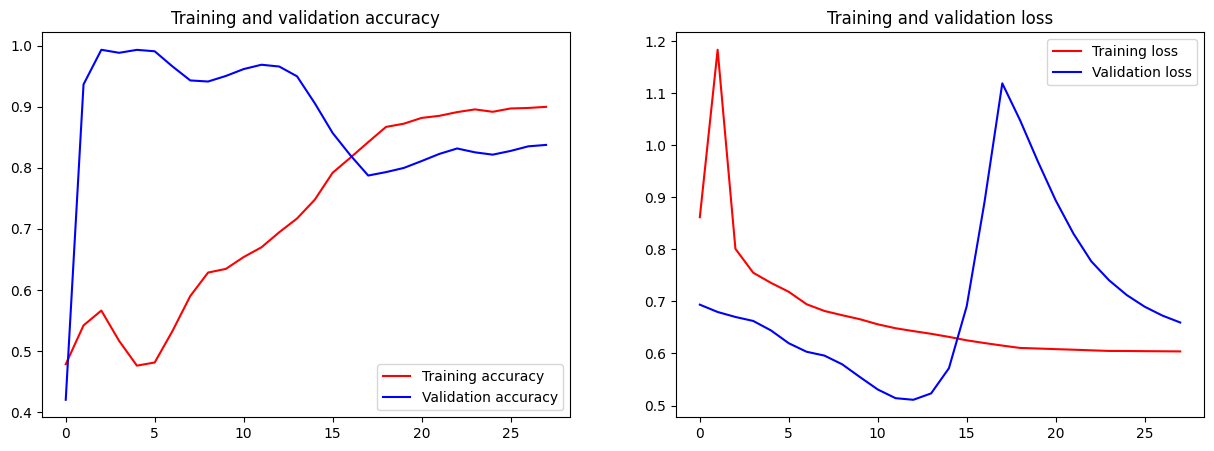

In [ ]:
plot_training_history(history)

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("binary_covid_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# make prediction for infection masks

predictions = model.predict(X_test_tensor)

# Threshold the predictions to obtain binary masks (if needed)
predicted_masks = (predictions > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 259ms/step


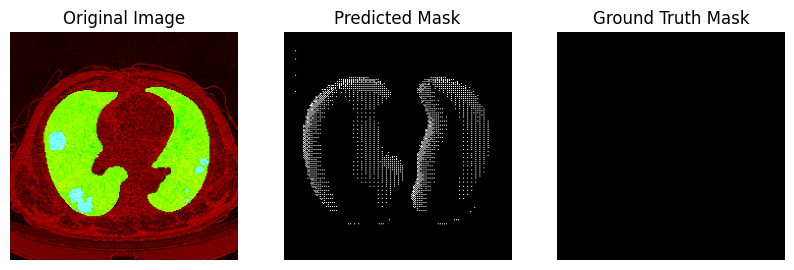

In [ ]:
import matplotlib.pyplot as plt

index = 3

original_image = X_test_tensor[index]
infection_mask = y_test_tensor[index]
predicted_mask = predicted_masks[index]


fig, axes = plt.subplots(1,3, figsize=(10,5))

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask, cmap="gray")
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(infection_mask, cmap="gray")
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()

Probably picked the wrong slice for the infection mask , when shaping the data for tensorflow. Learned the lung shape instead of the infection. The truth mask probably has been sliced wrong.